# Deep Q-Learning for training a Doom agent/player

In [52]:
import random 
from skimage import transform
from skimage.color import rgb2gray
import tensorflow as tf    
import time  
from vizdoom import *  
from collections import deque
import matplotlib.pyplot as plt 
import numpy as np 

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

## Creating the environment 

Doom environment takes:
* A configuration file that handle all the options (size of the frame, possible actions...)
* A scenario file: that generates the correct scenario (in our case basic).
* Note: We have 3 possible actions [[0,0,1], [1,0,0], [0,1,0]]

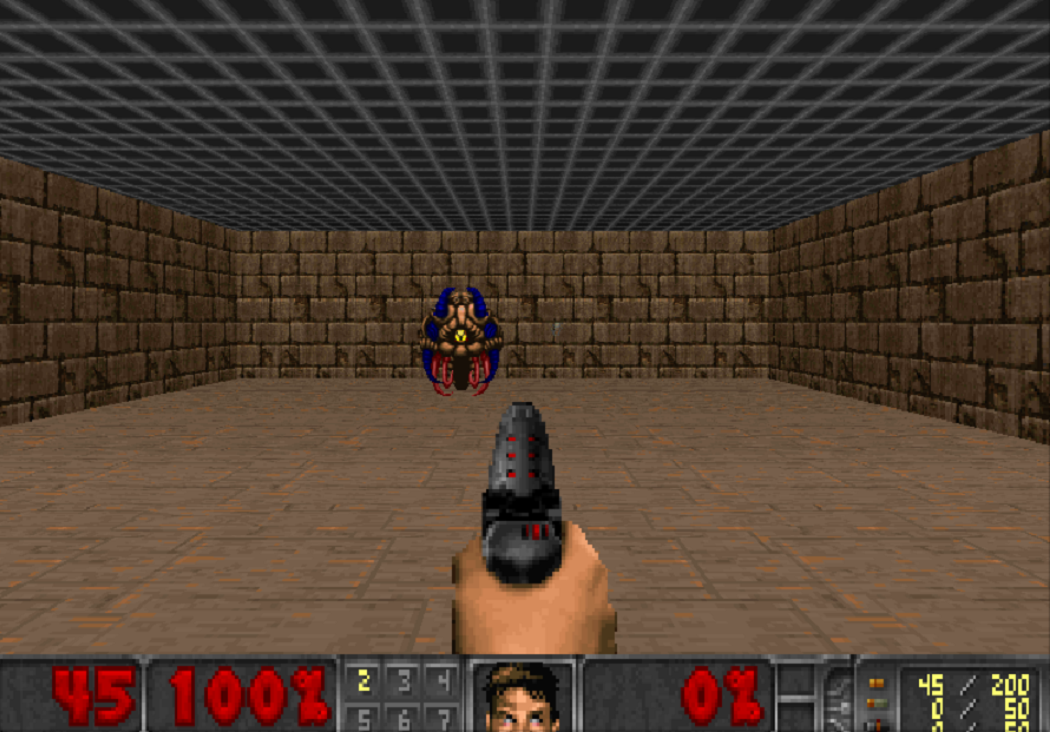

* A moving monster is placed randomly somewhere along the opposite wall.
* Player can only go left/right and shoot.
* 1 hit is enough to kill the monster.
* Episode finishes when monster is killed or on timeout (300).

REWARDS:

* +101 for killing the monster

* -5 for missing
* Episode ends after killing the monster or on timeout.
* living reward = -1

In [4]:
def create_doom_env():
    game = DoomGame()
    game.load_config("../../../AppData/Local/Continuum/miniconda3/envs/py372/Lib/site-packages/vizdoom/scenarios/basic.cfg")
    game.set_doom_scenario_path("../../../AppData/Local/Continuum/miniconda3/envs/py372/Lib/site-packages/vizdoom/scenarios/basic.wad")
    game.init()
    
    shoot = [0, 0, 1]
    left = [1, 0, 0]
    right = [0, 1, 0]
    possible_actions = [shoot, left, right]

    return game, possible_actions

In [37]:
def test_environment():
    game, actions = create_doom_env()
    episodes = 3
    for ep in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            game_vars = state.game_variables
            action = random.choice(actions)
            reward = game.make_action(action)
            print(reward)
            time.sleep(0.02)
        print("Result:", game.get_total_reward())
    game.close()

In [2]:
# test_environment()

## Define the preprocessing functions ⚙️

#### preprocess_frame

Preprocessing is an important step, because we want to reduce the complexity of our states to reduce the computation time needed for training.

1. Grayscale each of our frames (because color does not add important information ). But this is already done by the config file.
2. Crop the screen (in our case we remove the roof because it contains no information)
3. Normalize pixel values
4. Resize the preprocessed frame

In [65]:
new_size = (84, 84)
def preprocess_frame(frame):
    # Crop the screen (remove the roof because it contains no information)
    cropped_frame = frame[30:-10, 30:-30]
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    # Resize
    preprocessed_frame = transform.resize(normalized_frame, new_size)
    return preprocessed_frame

In [58]:
game, actions = create_doom_env()

In [59]:
state = game.get_state()

### Stack Frames

Stacking frames is really important because it helps us to have a sense of motion in our Neural Network.

* First we preprocess frame
* Then we append the frame to the deque that automatically removes the oldest frame
* Finally we build the stacked state

In particular,
* For the first frame, we feed 4 frames
* At each timestep, we add the new frame to deque and then we stack them to form a new stacked frame
* If we're done, we create a new stack with 4 new frames (because we are in a new episode).

In [63]:
stack_size = 4
stacked_frames = deque([np.zeros(new_size, dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    img = preprocess_frame(rgb2gray(state.screen_buffer.transpose(1, 2, 0)))
    if is_new_episode:
        for _ in range(stack_size):
            stacked_frames.append(img)
    else:
        stacked_frames.append(img)
    stacked_frames_numpy = np.stack(stacked_frames, axis=-1)
    return stacked_frames_numpy    

In [67]:
stacked_frames_numpy = stack_frames(stacked_frames, state, False)

In [68]:
stacked_frames_numpy.shape

(84, 84, 4)

### Hyperparameter setup

In [69]:
state_size = [84, 84, 4]  # Our input is a stack of 4 frames hence 84x84x4 (Width, height, channels) 
action_size = game.get_available_buttons_size()  # 3 possible actions: left, right, shoot
learning_rate =  0.0002  # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 500  # Total episodes for training
max_steps = 100   # Max possible steps in an episode
batch_size = 64             

# Exploration parameters for epsilon greedy strategy
epsiolon_start = 1.0  # exploration probability at start
epsilon_stop = 0.01  # minimum exploration probability 
decay_rate = 0.0001  # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.95  # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size  # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000   # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

### Implement our deep-Q network model

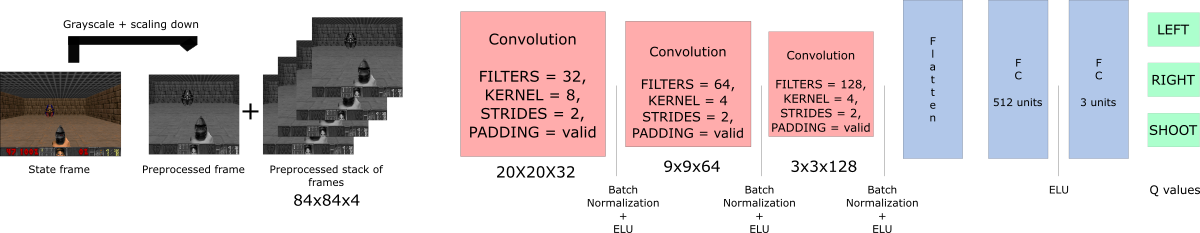

In [ ]:
class DQNetwork: